# Predicting Reddit Post Popularity

This code aims to predict the score of an Ask Reddit Post given the title text in combination with some metadata. It first attempts a baseline implementation using a simple sentiment analysis of the title in a Linear Regression model with Dummy Regressors. It proceeds to attempt more complex sentiment analysis using word embeddings and KNeighborsRegression.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from nltk import word_tokenize
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
import os

In [2]:
DATA_FILEPATH = '/home/ashuaibi7/project/data'
TRAIN_FILE = os.path.join(DATA_FILEPATH, 'train.csv')
DEV_FILE = os.path.join(DATA_FILEPATH, 'dev.csv')
TEST_FILE = os.path.join(DATA_FILEPATH, 'test.csv')
ALL_FILE = os.path.join(DATA_FILEPATH, 'all.csv')
GLOVE_FILE = os.path.join(DATA_FILEPATH, 'glove', 'glove.6B.300d.txt')
DIMENSION = 300     # Dimension of word embeddings used
RANDOM_SEED = 229

## Read in Data
Read the data processed in the process_data.ipynb into a pandas dataframe. Utilize the label binarizer to convert the non-numeric features into vectorized numeric ones.

In [3]:
df = pd.read_csv(ALL_FILE)
df.dropna(inplace=True)

In [4]:
lb = LabelBinarizer()
categorical = [lb.fit_transform(df[col]) for col in ['weekday', 'hour']]
boolean = [df[col].astype('int') for col in ['over_18', 'sentiment']]
numeric = df.loc[:, ['title_length', 'gilded', 'num_comments']].values

In [5]:
df.head()

,num_comments,title_length,sentiment,weekday,hour,gilded,over_18,score,title
0,1,35,0,0,0,0,False,1,What are your new year resolutions?
1,0,77,0,0,0,0,False,1,Are you planning to kill yourself before you g...
2,7,33,0,0,0,0,False,2,What is your embarrassing fetish?
3,5,44,0,0,0,0,False,0,What makes the Bible the only book of truth?
4,10,183,0,0,0,0,False,2,"Redditors that used to frequent forums, chat r..."


## Generate Average Word Embeddings as Features
We will do so using existing word embeddings provided by GloVe. Read in these embeddings with the function below.

In [6]:
# We will use the 300-dimension GloVe representations
def glove_dictionary(filename):
    data = {}
    with open(filename) as f:
        while True:
            try:
                line = next(f)
                line = line.strip().split()
                data[line[0]] = np.array(line[1: ], dtype = np.float)
            except StopIteration: break
            except UnicodeDecodeError: pass
    return data

In [7]:
glove_embeddings = glove_dictionary(GLOVE_FILE)

In [8]:
ps = PorterStemmer() 

In [9]:
def generate_embeddings():
    title_embeddings = []
    for index, row in df.iterrows():
        token_embeddings = []
        tokens = word_tokenize(row['title'].lower())
        for token in tokens:
            token = ps.stem(token)
            if token in glove_embeddings: token_embeddings.append(glove_embeddings[token])
        if len(token_embeddings) == 0: token_embeddings = [np.zeros(DIMENSION)]
        title_embeddings.append(np.mean(token_embeddings, axis=0))
    return title_embeddings

In [ ]:
# Average all the word embeddings in a title
title_embeddings = generate_embeddings()

In [ ]:
title_embeddings_features = np.stack(title_embeddings)

In [11]:
final = [numeric] + boolean + categorical + [title_embeddings_features]
x = np.column_stack(tuple(final))
y = df['score'].values

In [12]:
# Used to test functionalty. When running final evaluation, use TRAIN_FILE/DEV_FILE/TEST_FILE manually
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_SEED)

In [13]:
def r2_and_rmse(model, pr=True):
    y_predicted = model.predict(X_test)
    return [r2_score(y_test, y_predicted),np.sqrt(mean_squared_error(y_test, y_predicted))]
def plot(models, metric = 'RMSE'):
    r, rmse = [], []
    for key in models.keys():
        r.append(models[key][0])
        rmse.append(models[key][1])
    vals = pd.DataFrame([])
    vals['R-squared'], vals['RMSE'] = r, rmse
    vals.index = models.keys()
    # R-squared plot
    fig, ax = plt.subplots(figsize = (12,6))
    ax.bar(vals.index, vals['R-squared'], color='green')
    plt.xlabel('Model')
    plt.ylabel('R-squared')    
    plt.xticks(rotation = 45)
    
    # RMSE plot
    fig, ax = plt.subplots(figsize = (12,6))
    ax.bar(vals.index, vals['RMSE'], color='blue')
    plt.xlabel('Model')
    plt.ylabel('RMSE')    
    plt.xticks(rotation = 45)

In [14]:
# Repeat the notebook twice. Once using the word embeddings as features
# and once without to get the values below:
models = {
    'Baseline': [0.001, 645.19],
    'Linear': [0.7204, 355.14],
    'Linear_With_Embeddings': [0.7283, 353.74],
    'KNN': [0.7289, 353.22],
    'KNN_With_Embeddings': [0.7408, 344.32],
    'Random_Forest': [0.7764, 304.92],
    'Random_Forest_With_Embeddings': [0.7855, 301.32],
}

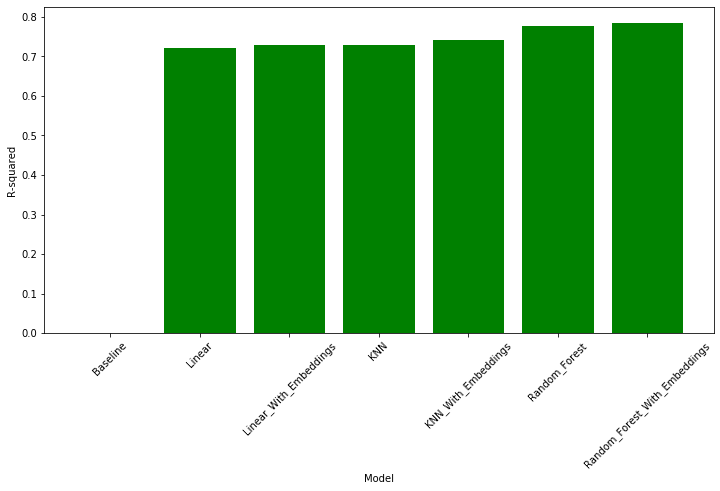

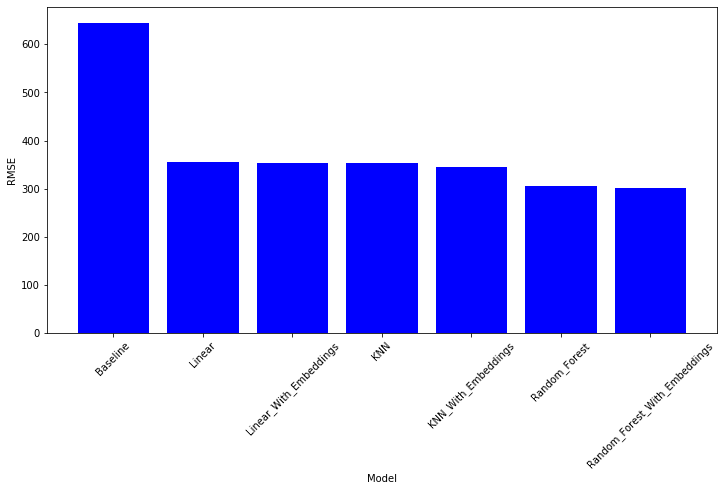

In [15]:
plot(models)

In [17]:
baseline = DummyRegressor(strategy='median')
baseline.fit(X_train,y_train)
linear = LinearRegression()
linear.fit(X_train,y_train)
knn_regression = KNeighborsRegressor()
knn_regression.fit(X_train, y_train)
random_forest_regression = RandomForestRegressor(n_jobs=-1, n_estimators=50, min_samples_leaf=10, random_state = RANDOM_SEED)
random_forest_regression.fit(X_train, y_train)

In [ ]:
r2_and_rmse(baseline)
r2_and_rmse(linear)
r2_and_rmse(knn_regression)
r2_and_rmse(random_forest_regression)

## Ablative Analysis
Remove one feature at a time and evaluate the percent decrease in R-squared

In [ ]:
# Manually remove one feature at a time and re-run subesquent cells keeping track of R-squared.
numeric_columns = ['title_length', 'gilded', 'num_comments']
categorical_columns = ['weekday', 'hour']
boolean_columns = ['sentiment']

In [ ]:
categorical = [lb.fit_transform(df[col]) for col in categorical_columns]

In [ ]:
boolean = [df[col].astype('int') for col in boolean_columns]

In [ ]:
numeric = df.loc[:, numeric_columns].values

In [ ]:
# Ablative Analysis
linear = LinearRegression()
final = [numeric] + boolean + categorical
y = df['score'].values
x = np.column_stack(tuple(final))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=RANDOM_SEED)

In [ ]:
linear.fit(X_train,y_train)
r2_and_rmse(linear)

In [ ]:
# Calculating percent decrease in r_squared values here
# x = 0.707978
# (0.7079716 - x)/ 0.7079716

In [ ]:
# Graph percent decrease per feature removed:
r_squared_by_feature = {
    'title_length': 0.0102405,
    'gilded': 02.103262,
    'num_comments': 80.7625757,
    'weekday': 5.50869554662452e-04,
    'hour': -3.1074692825986804e-04,
    'over_18': -9.039910640429631e-04,
    'sentiment': 1.6949832450923172e-03,
    'embeddings': 1.084714
}

In [ ]:
plt.bar(range(len(r_squared_by_feature)), list(r_squared_by_feature.values()), align='center')
plt.xticks(range(len(r_squared_by_feature)), list(r_squared_by_feature.keys()))
plt.title('R-Squared % Decrease vs. Feature')
plt.ylabel('R-Squared % Decrease')
plt.xlabel('Feature')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
# Get frequency of positive/negative sentiment posts
from collections import Counter
Counter(df['sentiment'])